## CATR Demo

In [17]:
!python catr_predict.py --path catr/.github/cake.png

2020-10-31 00:20:58.387418: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading Checkpoint v3...
A person cutting a cake with a knife.


In [3]:
!python catr_predict.py --path catr/.github/girl.png

2020-10-30 23:33:58.259660: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading Checkpoint v3...
A woman sitting on a curb holding an umbrella.


In [4]:
!python catr_predict.py --path catr/.github/office.png

2020-10-30 23:35:06.706842: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading Checkpoint v3...
A group of people sitting at desks with laptops.


In [8]:
!python catr_predict.py --path catr/.github/horse.png

2020-10-30 23:53:13.989625: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading Checkpoint v3...
A man riding a horse on a lush green hillside.


In [9]:
!python catr_predict.py --path catr/.github/airplane.png

2020-10-30 23:54:39.077654: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Loading Checkpoint v3...
A large plane is on a runway with a sky background


## Batch Prediction for fast processing

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np
import time
import sys
import os
import math
import tqdm

from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer, AutoTokenizer
from PIL import Image
import argparse

from catr.models import caption
from catr.models import utils as mtils
from catr.datasets import coco, utils
# from catr.cfg_damsm_bert import Config
from catr.configuration import Config

import json, pickle
from pycocotools.coco import COCO as CC
import matplotlib.pyplot as plt

In [2]:
# parser = argparse.ArgumentParser(description='Image Captioning')
# parser.add_argument('--path', type=str, help='path to image', required=True)
# parser.add_argument('--v', type=str, help='version', default='v3')
# args = parser.parse_args()
image_path = 'catr/.github/airplane.png'
image_path2 = 'catr/.github/cake.png'
version = 'v3'

config = Config()
device = torch.device(config.device)

model, criterion = caption.build_model(config)
model.to(device)

print("Loading Checkpoint...")
checkpoint = torch.load('catr/checkpoint_v3.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
# config.start_epoch = checkpoint['epoch'] + 1

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)

Loading Checkpoint...


In [3]:
# # set torch hub path for model cache
# torch.hub.set_dir('catr/.cache/hub')
# if version == 'v1':
#     modelr = torch.hub.load('saahiluppal/catr', 'v1', pretrained=True)
# elif version == 'v2':
#     modelr = torch.hub.load('saahiluppal/catr', 'v2', pretrained=True)
# elif version == 'v3':
#     modelr = torch.hub.load('saahiluppal/catr', 'v3', pretrained=True)
# else:
#     raise NotImplementedError('Version not implemented')

Using cache found in catr/.cache/hub/saahiluppal_catr_master
Downloading: "https://github.com/saahiluppal/catr/releases/download/0.2/weight493084032.pth" to catr/.cache/hub/checkpoints/weight493084032.pth


In [3]:
def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [4]:
# previous version for single image
@torch.no_grad()
def predict1(f):
    model.eval()
    image_path = os.path.join(dataPath, split, f['file_name'])
    image = Image.open(image_path)
    image = coco.val_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    caption, cap_mask = create_caption_and_mask(
        start_token, config.max_position_embeddings)
    caption = caption.to(device)
    cap_mask = cap_mask.to(device)
    for i in range(config.max_position_embeddings - 1):
        predictions = model(image, caption, cap_mask)
        predictions = predictions[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)

        if predicted_id[0] == 102:
            return caption

        caption[:, i+1] = predicted_id[0]
        cap_mask[:, i+1] = False

    return caption

In [5]:
# modified predict() for predicting all the captions on val_set
@torch.no_grad()
def predict(imgs):
    model.eval()
    outputs = []
    for f in tqdm.tqdm(imgs):
        image_path = os.path.join(dataPath, split, f['file_name'])
#         print(image_path)
        image = Image.open(image_path)
        image = coco.val_transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)
#         print(image.shape)
        caption, cap_mask = create_caption_and_mask(
            start_token, config.max_position_embeddings)
        caption = caption.to(device)
        cap_mask = cap_mask.to(device)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(image, caption, cap_mask)
    #         print(predictions.shape)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)

            if predicted_id[0] == 102:
#                 return caption
                break

            caption[:, i+1] = predicted_id[0]
            cap_mask[:, i+1] = False
#         print(caption)
        outputs.append({'image_id': f['id'], 'caption': caption[0].cpu().detach().numpy()})

    return outputs

In [6]:
dataPath = '/media/MyDataStor2/zhanghex/coco2017'
dataType = 'captions'
split = 'val2017'
annFile = os.path.join(dataPath, 'annotations', '%s_%s.json' % (dataType, split))
cc = CC(annFile)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [7]:
img = cc.dataset['images']
print('Total number of images: %d' % len(img))
print('Image example: ' + str(img[0]) + '\n')

ann = cc.dataset['annotations']
print('Total number of annotations: %d' % len(ann))
print('Annotation example: ' + str(ann[0]))

Total number of images: 5000
Image example: {'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}

Total number of annotations: 25014
Annotation example: {'image_id': 179765, 'id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.'}


In [8]:
# predict all the captions for validation set
res = predict(img[:2])

for i, it in enumerate(res):
    cap = tokenizer.decode(it['caption'].tolist(), skip_special_tokens=True)
    res[i]['caption'] = cap.capitalize()

print(res)

100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

[{'image_id': 397133, 'caption': 'A group of people standing around a kitchen preparing food.'}, {'image_id': 37777, 'caption': 'A kitchen with a stove a sink and a refrigerator'}]


In [19]:
resCaps = []
for f in tqdm.tqdm(img): 
    output = predict1(f)
    result = tokenizer.decode(output[0].tolist(), skip_special_tokens=True)
#     print(result.capitalize())
    resCaps.append({'image_id': f['id'], 'caption': result.capitalize()})

 21%|██        | 1039/5000 [09:08<34:52,  1.89it/s]


KeyboardInterrupt: 

In [24]:
# save the predicted captions to json for cocoeval
with open('./results/captions_val2017_results.json', 'w') as ff:
    json.dump(resCaps, ff)

## Test evaluate() on data_loaders

In [9]:
tokenizer = BertTokenizer.from_pretrained("catr/damsm_vocab.txt", do_lower=True)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [10]:
from catr.cfg_damsm_vocab import Config
config = Config()

dataset_train = coco.build_dataset_v3(config, mode='training')
dataset_val = coco.build_dataset_v3(config, mode='validation')
print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, config.batch_size, drop_last=True
)

data_loader_train = DataLoader(
    dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                             sampler=sampler_val, drop_last=False)

Train: 414113
Valid: 202654


<font size="5" color='brown'>
Here is a short visualization for the dataloader
</font>

In [22]:
it = iter(data_loader_train).next()
img, mask, cap, cap_mask = it

In [23]:
print(cap[15][:20])
print(cap_mask[15][:20])
print(cap[15][~cap_mask[15]])
print(cap.shape)

tensor([27297,    10,    59,   604,   379,    82,    34,    10,    38,    21,
          811,   805, 27298,     0,     0,     0,     0,     0,     0,     0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,  True])
tensor([27297,    10,    59,   604,   379,    82,    34,    10,    38,    21,
          811,   805, 27298])
torch.Size([32, 129])


In [37]:
result = tokenizer.batch_decode(cap.tolist(), skip_special_tokens=True)
for j, rcap in enumerate(result): 
    print('%02d: ' % j + rcap.capitalize(), sep='\n')

00: Phone on dock with speakers and glass live digitally
01: A person in a wet suite running beside the water holding a surfboard
02: A young man is holding an umbrella in the rain
03: A stop sign is in the middle of trees
04: A man is spray painting a light blue tarp
05: A brown clock tower with skyline in the background
06: A man and woman sitting on a couch near a cake stand and dishes
07: Small cart with assorted suitcases at curbside on sidewalk
08: A person with a bottle and a backpack
09: A policeman sitting with a dalmatian near a building with another couple at the other end with another dog
10: A one way sign that is hanging next to a red light in front of a building
11: A young woman standing on the edge of a boat looking over the railing
12: A tray with a variety of food including carrots
13: A tennis player preparing to swing her racket
14: A man in mid air doing a water skiing trick
15: A white plate filled up with a lot of glazed donuts
16: A kitchen filled with an empty

tensor(-0.9294) tensor(1.)


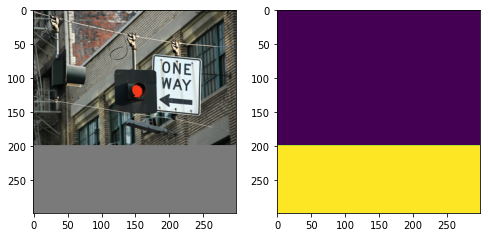

In [39]:
i = 10
# print(img[i].min(), img[i].max())
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow((img[i].numpy().transpose((1,2,0)) - img[i].min().numpy()) / (img[i].max() - img[i].min()).numpy())
fig.add_subplot(1,2,2)
plt.imshow(mask[i].numpy().astype(int))
plt.show()

In [11]:
@torch.no_grad()
def evaluate(data_loader):
    model.eval()
#     total = len(data_loader)

    for images, masks, caps, cap_masks in data_loader:
        samples = mtils.NestedTensor(images, masks).to(device)
        caps = caps.to(device)
        cap_masks = cap_masks.to(device)
        outputs = model(samples, caps[:, :-1], cap_masks[:, :-1])
        break   # only used for debug, inspect 1st iter
                
    return outputs

In [16]:
from catr.cfg_damsm_bert import Config
config = Config()

dataset_train = coco.build_dataset14(config, mode='training')
dataset_val = coco.build_dataset14(config, mode='validation')
print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, config.batch_size, drop_last=True
)

data_loader_train = DataLoader(
    dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                             sampler=sampler_val, drop_last=False)

Train: 414113
Valid: 202654


In [20]:
# captions from evaluate() on train/val_set
output = evaluate(data_loader_val)
pred = torch.argmax(output, axis=-1).cpu().detach().numpy()

cp = tokenizer.batch_decode(pred.tolist(), skip_special_tokens=True)
for p in cp:
    print(p, sep='\n')

a bicycle with clock a clock on roman bottom wheel.
a motorcycle motorcycle motorcycle parked in a of a house.
a bathroom with a walls and a white sink. a.
a car is is to be parked on on a bench. car.
a large jet jet taking through the sky.
a is a largeur plane taking off from the clear cloudy sky
a bathroom white bathroom bathroom with a blue bathroom.
a bathroom a bathroom bathroom white bathroom with a white toilet mirror mirror sizede the wall.
a bathroom bathroom with bathroom with a reflection saver. the wall.
a bike is a clock on well man.
a motorcycle motorcycle is in a yard field.
a cars parked on a side next a sidewalk.
a airplane taking is flying flying taking flying or taking taking off.
a bathroom with a and has white blue..
a bathroom with a toilet, sink, and bath.
a kitchen narrow kitchen emptyist kitchenhen kitchen kitchen
a office withle with a computers computers of computers.
a bathroom sink with aries on the counter.
a toilet bathroom toilet in a small bathroom
a pe

## Predict captions in batch

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np
import time
import sys
import os
import math
import tqdm

from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer, AutoTokenizer
from PIL import Image
import argparse

from catr.models import caption
from catr.models import utils as mtils
from catr.datasets import coco, utils
# from catr.cfg_damsm_bert import Config
from catr.configuration import Config

import json, pickle
from pycocotools.coco import COCO as CC
import matplotlib.pyplot as plt

In [5]:
# parser = argparse.ArgumentParser(description='Image Captioning')
# parser.add_argument('--path', type=str, help='path to image', required=True)
# parser.add_argument('--v', type=str, help='version', default='v3')
# args = parser.parse_args()
image_path1 = 'catr/.github/airplane.png'
image_path2 = 'catr/.github/cake.png'
version = 'v3'

config = Config()
device = torch.device(config.device)

model, criterion = caption.build_model(config)
model.to(device)

print("Loading Checkpoint...")
checkpoint = torch.load('catr/checkpoint_v3.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
# config.start_epoch = checkpoint['epoch'] + 1

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)

Loading Checkpoint...


In [2]:
def create_caption_and_mask(start_token, max_length, bn=1):
    caption_template = torch.zeros((bn, max_length), dtype=torch.long)
    mask_template = torch.ones((bn, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [3]:
# used for batch prediction for speed up
@torch.no_grad()
def predict_batch_test(model, imgs, end_token):
    model.eval()
    caption, cap_mask = create_caption_and_mask(
            start_token, config.max_position_embeddings, bn=2)
    caption = caption.to(device)
    cap_mask = cap_mask.to(device)
#     imgs = mtils.NestedTensor(imgs.tensors, imgs.mask).to(device)
    imgs = imgs.to(device)
#     print(isinstance(samples, NestedTensor))
#     image, mask = imgs.decompose()
    b = torch.zeros((caption.shape[0])).bool().to(device)
    for i in range(config.max_position_embeddings - 1):
        predictions = model(imgs, caption, cap_mask)
        predictions = predictions[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)
        end_flag = predicted_id == end_token
        b = b.logical_or(end_flag)

        if b.all(): # all the caption predictions reaches end_token, return
            break

        caption[~b, i+1] = predicted_id[~b]
        cap_mask[~b, i+1] = False

    return caption

In [6]:
image1 = Image.open(image_path1)
image1 = coco.val_transform(image1)
# image1 = image1.unsqueeze(0)
image2 = Image.open(image_path2)
image2 = coco.val_transform(image2)
# image2 = image2.unsqueeze(0)
image = [image1, image2]
image = utils.nested_tensor_from_tensor_list(image)
image = mtils.NestedTensor(image.tensors, image.mask) # have to use NestedTensor from models.utils
print(image.tensors.shape, image.mask.shape)
print(isinstance(image, mtils.NestedTensor))

torch.Size([2, 3, 299, 299]) torch.Size([2, 299, 299])
True


In [7]:
results = predict_batch_test(model, image, end_token)
print(results)
captions = tokenizer.batch_decode(results.tolist(), skip_special_tokens=True)
for p in captions:
    print(p, sep='\n')

tensor([[ 101, 1037, 2312, 4946, 2003, 2006, 1037, 9271, 2007, 1037, 3712, 4281,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 1037, 2711, 6276, 1037, 9850, 2007, 1037, 5442, 1012,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 

### Batch prediction on val set

In [9]:
from catr.configuration import Config
config = Config()

# dataset_train = coco.build_dataset(config, mode='training')
dataset_val = coco.build_dataset(config, mode='validation')
# print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

# sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# batch_sampler_train = torch.utils.data.BatchSampler(
#     sampler_train, config.batch_size, drop_last=True
# )

# data_loader_train = DataLoader(
#     dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, config.batch_size,
                             sampler=sampler_val, drop_last=False)

Valid: 25014


In [18]:
# used for batch prediction for speed up
@torch.no_grad()
def predict_batch(model, data_loader, end_token):
    model.eval()
    outputs = []
    for images, masks, _, _ in data_loader:
        caption, cap_mask = create_caption_and_mask(
                start_token, config.max_position_embeddings, bn=images.shape[0])
        caption = caption.to(device)
        cap_mask = cap_mask.to(device)
        imgs = mtils.NestedTensor(images, masks).to(device)
        b = torch.zeros((caption.shape[0])).bool().to(device)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(imgs, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)
            end_flag = predicted_id == end_token
            b = b.logical_or(end_flag)

            if b.all(): # all the caption predictions reaches end_token, return
                break

            caption[~b, i+1] = predicted_id[~b]
            cap_mask[~b, i+1] = False
        
        outputs.append(caption)
        break

    return outputs

In [19]:
# the results look good enough
results = predict_batch(model, data_loader_val, end_token)
print(results)
captions = tokenizer.batch_decode(results[0].tolist(), skip_special_tokens=True)
for p in captions:
    print(p, sep='\n')

[tensor([[ 101, 1037, 9055,  ...,    0,    0,    0],
        [ 101, 1037, 9055,  ...,    0,    0,    0],
        [ 101, 1037, 4624,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 4624,  ...,    0,    0,    0],
        [ 101, 1037, 3829,  ...,    0,    0,    0],
        [ 101, 1037, 5127,  ...,    0,    0,    0]], device='cuda:2')]
a motorcycle parked in a field of grass.
a motorcycle parked in a field of grass.
a desk with a computer and a laptop on it.
a toilet with a wooden seat and a sink
a woman is riding a bike down the street
a motorcycle parked in a field of grass.
a toilet with a wooden seat and a sink
a desk with a computer and a laptop on it.
a plate with a piece of cake and a fork on it.
a woman is riding a bike down the street
a woman is riding a bike down the street
a toilet with a wooden seat and a sink
a cat is sniffing a dead bird on the ground.
a toilet with a wooden seat and a sink
a man in a blue shirt is holding a spoon
a cat walking on the grass next to

In [34]:
######## make the data_loader only load images once #############
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision as tv

from PIL import Image
import numpy as np
import random
import os, pickle, json

from catr.configuration import Config

# from transformers import BertTokenizer

from catr.datasets.utils import nested_tensor_from_tensor_list

MAX_DIM = 299


def under_max(image):
    if image.mode != 'RGB':
        image = image.convert("RGB")

    shape = np.array(image.size, dtype=np.float)
    long_dim = max(shape)
    scale = MAX_DIM / long_dim

    new_shape = (shape * scale).astype(int)
    image = image.resize(new_shape)

    return image


class RandomRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle, expand=True)


train_transform = tv.transforms.Compose([
    RandomRotation(),
    tv.transforms.Lambda(under_max),
    tv.transforms.ColorJitter(brightness=[0.5, 1.3], contrast=[
                              0.8, 1.5], saturation=[0.2, 1.5]),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transform = tv.transforms.Compose([
    tv.transforms.Lambda(under_max),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class CocoImage17(Dataset):
    def __init__(self, root, ann, transform=train_transform, mode='training'):
        super().__init__()

        self.root = root
        self.transform = transform
        self.annot = [val['id'] for val in ann['images']]
        if mode == 'validation':
            self.annot = self.annot
        if mode == 'training':
            self.annot = self.annot

    def _process(self, image_id):
        val = '%012d.jpg' % image_id
        return val

    def __len__(self):
        return len(self.annot)

    def __getitem__(self, idx):
        image_id = self.annot[idx]
        image = Image.open(os.path.join(self.root, self._process(image_id)))

        if self.transform:
            image = self.transform(image)
        image = nested_tensor_from_tensor_list(image.unsqueeze(0))

        return image.tensors.squeeze(0), image.mask.squeeze(0), image_id
    
    
def data_maker(config, mode='training'):
    if mode == 'training':
        train_dir = os.path.join(config.dir, 'train2017')
        train_file = os.path.join(
            config.dir, 'annotations', 'captions_train2017.json')
        with open(train_file, 'r') as f:
            trf = json.load(f)
        data = CocoImage17(train_dir, trf, transform=train_transform, mode='training')
        return data

    elif mode == 'validation':
        val_dir = os.path.join(config.dir, 'val2017')
        val_file = os.path.join(
            config.dir, 'annotations', 'captions_val2017.json')
        with open(val_file, 'r') as f:
            vlf = json.load(f)
        data = CocoImage17(val_dir, vlf, transform=val_transform, mode='validation')
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")

In [38]:
# used for batch prediction for speed up
@torch.no_grad()
def predict_final(model, data_loader, tokenizer):
    model.eval()
    outputs = []
    start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
    end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)
    for images, masks, fn in data_loader:
        caption, cap_mask = create_caption_and_mask(
                start_token, 128, bn=images.shape[0])
        caption = caption.to(device)
        cap_mask = cap_mask.to(device)
        imgs = mtils.NestedTensor(images, masks).to(device)
        b = torch.zeros((caption.shape[0])).bool().to(device)
        for i in range(config.max_position_embeddings - 1):
            predictions = model(imgs, caption, cap_mask)
            predictions = predictions[:, i, :]
            predicted_id = torch.argmax(predictions, axis=-1)
            end_flag = predicted_id == end_token
            b = b.logical_or(end_flag)

            if b.all(): # all the caption predictions reaches end_token, return
                break

            caption[~b, i+1] = predicted_id[~b]
            cap_mask[~b, i+1] = False
        
        results = tokenizer.batch_decode(caption.tolist(), skip_special_tokens=True)
        for i in range(len(results)):
            outputs.append({'image_id': fn[i].item(), 'caption': results[i].capitalize()})
        break

    return outputs

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

config = Config()

# dataset_train = coco.build_dataset(config, mode='training')
dataset_val = data_maker(config, mode='validation')
# print(f"Train: {len(dataset_train)}")
print(f"Valid: {len(dataset_val)}")

# sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

# batch_sampler_train = torch.utils.data.BatchSampler(
#     sampler_train, config.batch_size, drop_last=True
# )

# data_loader_train = DataLoader(
#     dataset_train, batch_sampler=batch_sampler_train)
data_loader_val = DataLoader(dataset_val, 64,
                             sampler=sampler_val, drop_last=False)

Valid: 5000


In [39]:
results = predict_final(model, data_loader_val, tokenizer)
for res in results:
    print(res, sep='\n')

{'image_id': 397133, 'caption': 'A group of people standing around a kitchen preparing food.'}
{'image_id': 37777, 'caption': 'A kitchen with a stove a sink and a refrigerator'}
{'image_id': 252219, 'caption': 'A group of people standing outside of a blue train.'}
{'image_id': 87038, 'caption': 'A man riding a skateboard down a flight of steps.'}
{'image_id': 174482, 'caption': 'A bike is parked on the side of the street'}
{'image_id': 403385, 'caption': 'A bathroom with a toilet, bathtub and a bathtub.'}
{'image_id': 6818, 'caption': 'A bathroom with a toilet and a sink.'}
{'image_id': 480985, 'caption': 'A motorcycle is displayed in a store window.'}
{'image_id': 458054, 'caption': 'A row of toilets sitting on top of a dirt field.'}
{'image_id': 331352, 'caption': 'A toilet with a wooden seat and a sink'}
{'image_id': 296649, 'caption': 'A group of people riding motorcycles down a street.'}
{'image_id': 386912, 'caption': 'A woman sitting at a desk with a laptop.'}
{'image_id': 50213

In [20]:
with open('/media/MyDataStor2/zhanghex/coco2017/annotations/captions_train2017.json', 'r') as f:
    cocod = json.load(f)

In [24]:
cocod['images'][0]

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

Logic of batch prediction (below)

In [16]:
a = torch.Tensor([[1,1,1,0], [1,0,0,0], [1,1,0,0]]).long()
b = torch.Tensor([True, True, True]).bool()
c = torch.Tensor([[3,4,5], [6,7,8], [9,10,11]]).long().t()
print(a, b.shape, c, sep='\n')

tensor([[1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0]])
torch.Size([3])
tensor([[ 3,  6,  9],
        [ 4,  7, 10],
        [ 5,  8, 11]])


In [71]:
for i in range(len(a[0])-1):
    b = b.logical_and(a[:,i+1] == 1)
    a[b,i+1] = c[b,i]
    print(b.any())
print(a)

tensor(True)
tensor(True)
tensor(False)
tensor([[1, 3, 6, 0],
        [1, 0, 0, 0],
        [1, 5, 0, 0]])


In [75]:
(a[:,-1] == 0).all() # .any()

tensor(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 199, 299])


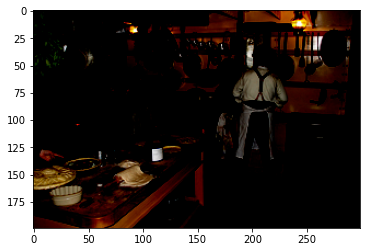

In [75]:
image_path = os.path.join(dataPath, split, img[0]['file_name'])
image = Image.open(image_path)
image = coco.val_transform(image)
print(image.shape)
plt.imshow(image.cpu().numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 299, 299])


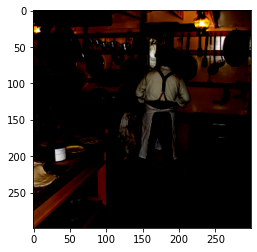

In [81]:
tr_transform = transforms.Compose([
    transforms.Scale(299),
    transforms.RandomCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image_path = os.path.join(dataPath, split, img[0]['file_name'])
image = Image.open(image_path)
image = tr_transform(image)
print(image.shape)
plt.imshow(image.cpu().numpy().transpose((1,2,0)))

In [1]:
import torch

In [3]:
check = torch.load('/media/MyDataStor2/zhanghex/torch-master/MMRL/code/catr/checkpoints/catr_damsm256_proj_vocab_coco2014_ep09.pth', map_location='cpu')

In [7]:
print(check.keys())
print(check['optimizer'].keys())
print(check['optimizer']['param_groups'][0].keys())
print(check['lr_scheduler'].keys())

dict_keys(['model', 'optimizer', 'lr_scheduler', 'epoch'])
dict_keys(['state', 'param_groups'])
dict_keys(['lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'initial_lr', 'params'])
dict_keys(['step_size', 'gamma', 'base_lrs', 'last_epoch', '_step_count', '_get_lr_called_within_step', '_last_lr'])


In [8]:
print(check['optimizer']['param_groups'][0])
print(check['lr_scheduler'])

{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'initial_lr': 0.0001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195]}
{'

In [8]:
config = Config()
optimizer = torch.optim.AdamW(
        model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
sch_t = torch.optim.lr_scheduler.StepLR(optimizer, config.lr_drop)
print(sch_t.state_dict())
print(optimizer.state_dict()['param_groups'][0])

{'step_size': 3, 'gamma': 0.1, 'base_lrs': [0.0001], 'last_epoch': 0, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.0001]}
{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'initial_lr': 0.0001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 1

In [11]:
sch_t.step()
print(sch_t.state_dict())
print(optimizer.state_dict()['param_groups'][0])

{'step_size': 3, 'gamma': 0.1, 'base_lrs': [0.0001], 'last_epoch': 3, '_step_count': 4, '_get_lr_called_within_step': False, '_last_lr': [1e-05]}
{'lr': 1e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'initial_lr': 0.0001, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167

In [14]:
sch_t.base_lrs[0] = 1e-5
sch_t._last_lrs[0] = 1e-5
sch_t.state_dict()

{'step_size': 0,
 'gamma': 0.1,
 'base_lrs': [1e-05],
 'last_epoch': 0,
 '_step_count': 1,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.0001]}